## 2017 X-class flare observed with GOES-16: HRC shield rate proxy calibration

From Brian Kress (NOAA affiliate):

<blockquote>
The Sept. 2017 GOES-16 SGPS dataset and comparison plots with GOES-13 and -15 EPS/EPEAD are now available under the "Special Event Data" tab on the NOAA-NCEI website.
<br><br>
https://www.ngdc.noaa.gov/stp/satellite/goes-r.html
<br><br>
ftp://ftp.ngdc.noaa.gov/STP/goesr/solar_proton_events/sgps_sep2017_event_data/
<br><br>
A paper describing SGPS measurements, this dataset and applied corrections will be available soon.
</blockquote>

In particular, Brian verified that
<blockquote>
(...) both G14 and G15 have P5 background rates 0.016-0.019 (p/cm^2-s-sr-MeV), in 2017 to 2020, in the data archived under https://www.ngdc.noaa.gov/stp/satellite/goes/dataaccess.html. Given that G14 and G15 are in agreement in the NCEI data, I expect the lower SWPC G14 backgrounds [that MTA recorded in realtime] are due to some difference in SWPC’s processing of G14 vs. G15, not instrument level differences. My guess is that there was some background subtraction and floor being used on G14, but I’m really not sure of this. Questions about it would have to be directed at SWPC.
</blockquote>

Brian's comment on comparing background levels from different instruments:

<blockquote>
(...) background rates [are] due to GCR [Galactic Cosmic Ray] counts picked up by the high energy tail ("out-of-band") portion of the response function. The EPEAD (and G16 SGPS) differential channels are designed to measure SEP [Solar Energetic Particles] fluxes with a steep spectrum, not GCRs. The background levels are in general different for different instruments (although we do expect them to be similar for the different EPEADs on G13-G15). Actual GCR fluxes at EPEAD P5 energies are ~10^-5 - 10^-4 (p/cm^2-s-sr-MeV), way below the background level. If we see order of magnitude differences between fluxes reported during, e.g., the Sept. 2017 GLE, then there is some problem, but I would not worry too much about comparing background levels from the different EPEADs and SGPSs.
</blockquote>


In [1]:
%matplotlib inline
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
import matplotlib.pyplot as plt
import tables
from astropy.time import Time
from Ska.Matplotlib import plot_cxctime
from Ska.engarchive import fetch as fetch
from Chandra.Time import DateTime
from netCDF4 import Dataset as NCDataset

In [2]:
# start and end times for the 2017 flare file
FLARE_START_TIME = '2017-09-01T00:00:00.000'
FLARE_END_TIME = '2017-10-01T00:00:00.000'

# GOES-16 data format constants
RECORDS = 8640
UNITS = 2
CHANNELS = 14
DIFF_CHANNELS = 13

# HRC Proxy (old) coeeficients, AA * chan0 + BB * chan1 + CC * chan2
AA = 6000
BB = 270000
CC = 100000

In [3]:
def convert_j2000_to_chandra_time(times):
    t1 = Time('1998-01-01T00:00:00')
    t2 = Time('2000-01-01T12:00:00')
    dt = t2 - t1  # Difference between two Times
    return times + dt.sec


def get_sgps_g16_proton_data(filename):
    """
    read SGPS Sept. 2017 event data
    B. Kress, Jan. 2021
    """
    # arrays for timestamps and fluxes
    TimeStamp = np.zeros([RECORDS], dtype=np.float64)
    ProtonFluxes = np.zeros([RECORDS, UNITS, CHANNELS], dtype=np.float32)

    # open file and read data set
    ds = NCDataset(filename, mode='r' )
    num_records = len(ds.variables['L2_SciData_TimeStamp'][:])
    TimeStamp[0:num_records] = ds.variables['L2_SciData_TimeStamp'][:]
    ProtonFluxes[0:num_records,:,0:DIFF_CHANNELS] = ds.variables['AvgDiffProtonFlux'][:,:,:]
    ProtonFluxes[0:num_records,:,DIFF_CHANNELS] = ds.variables['AvgIntProtonFlux'][:,:]
    ds.close()
    
    times = convert_j2000_to_chandra_time(TimeStamp)

    return times, ProtonFluxes


def get_arc_goes_data():
    # Retrieve GOES data archived through Replan Central (arc)
    h5_file = "/proj/sot/ska/data/arc3/hrc_shield.h5"
    out = {}

    with tables.open_file(h5_file, mode='r',
                          filters=tables.Filters(complevel=5, complib='zlib')) as h5:
        table = h5.root.data

    h5 = tables.open_file(h5_file, mode='r')
    table = h5.root.data
    
    out['sat'] = table.col('satellite')
    out['secs'] = table.col('time')
    out['p1'] = table.col('p1')
    out['p2a'] = table.col('p2a')
    out['p2b'] = table.col('p2b')
    out['p3'] = table.col('p3')
    out['p4'] = table.col('p4')
    out['p5'] = table.col('p5')
    out['p6'] = table.col('p6')
    out['p7'] = table.col('p7')
    out['p8a'] = table.col('p8a')
    out['p8b'] = table.col('p8b')
    out['p8c'] = table.col('p8c')
    out['p9'] = table.col('p9')
    out['hrc_shield'] = table.col('hrc_shield')
    h5.close()
    
    return out


def calc_HRCProxy(proton_fluxes):
    hrc_proxy = AA * proton_fluxes[0] + BB * proton_fluxes[1] + CC * proton_fluxes[2]
    return hrc_proxy / 256


def plot_format(ax, k):
    plt.yscale('log')
    plt.ylabel('protons/cm$^2$-s-sr-MeV')
    if k == 0:
        textstr = 'SGPS-X (west)'
    elif k == 1:
        textstr = 'SGPS+X (east)'
    ax.text(0.05, 0.97, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top')
    plt.grid()
    plt.legend(loc='upper right', prop={'size': 10})

    
def plot_compare_flare_profiles(k, old_goes, new_goes, color, ylabel=True):
    """
    Compare pre-GOES-16 and GOES-16 channels
    """
    # GOES-16
    plot_cxctime(TimeStamp[:], ProtonFluxes[:, k, new_goes] * 1000,
                 color=f'C{color}', label=f'{chan_label_g16[new_goes]} GOES-16',
                 alpha=0.7)
    # GOES-13/15, arc a.k.a. Replan Central
    plot_cxctime(goes_arc['secs'], goes_arc[f'p{old_goes}'],
                 color=f'C{color}', label=chan_label_pre_g16[old_goes - 4],
                 alpha=0.3)
    ax = plt.gca()
    plot_format(ax, k)
    plt.xlim(DateTime(FLARE_START_TIME).plotdate, DateTime(FLARE_END_TIME).plotdate)
    plt.ylim(8e-5, 300)
    if not ylabel:
        plt.ylabel('')

        
def plot_compare_old_new_proxy(k, arc_time_flt,
                               hrcproxy, hrcproxy_correction,
                               shld_dat, shld_time_flt):

    # GOES-13/15, arc a.k.a. Replan Central
    plot_cxctime(goes_arc['secs'][arc2017_flt],
                 goes_arc['hrc_shield'][arc2017_flt],
                 color='lightgray', label="HRC Proxy old GOES data")
    # GOES-16
    plot_cxctime(TimeStamp[:], HRCProxy_2017[:, k] + hrcproxy_correction,
                 color='gray', label="HRC Proxy GOES-16 data")
    # HRC shield rate, Chandra telemetry
    plot_cxctime(shld2017.times[shld2017_flt], shld2017.vals[shld2017_flt],
                 color='mediumseagreen', marker='.', ls='None', label=f"2SHLDART (HRC shield telemetry)")
    # Limits
    plt.hlines([80], DateTime(FLARE_START_TIME).plotdate, DateTime(FLARE_END_TIME).plotdate,
               color='gold', linestyle=(0, (10, 4)))
    plt.hlines([250], DateTime(FLARE_START_TIME).plotdate, DateTime(FLARE_END_TIME).plotdate,
               color='crimson', linestyle=(0, (10, 4)))

    ax = plt.gca()
    plot_format(ax, k)
    plt.ylabel('2SHLDART // 256')

    
def plot_telemetry_proxy_model(arc_time_flt, hrcproxy, hrcproxy_correction,
                               shld_dat, shld_time_flt):
    plot_cxctime(goes_arc['secs'][arc2020_flt], HRCProxy_Cflare + hrcproxy_correction,
             color='gray', label="HRCProxy GOES-16 data")
    plot_cxctime(shld2020.times[shld2020_flt], shld2020.vals[shld2020_flt],
             color='mediumseagreen', marker='.', ls='None', label="2SHLDBRT (HRC shield telemetry)")
    x1 = DateTime('2020:329').plotdate
    x2 = DateTime('2020:354').plotdate
    plt.hlines([250], x1, x2, color='crimson', linestyle=(0, (10, 4)))
    plt.hlines([80], x1, x2, color='gold', linestyle=(0, (10, 4)))
    ax = plt.gca()
    plot_format(ax, k)
    plt.xlim([x1, x2])
    plt.ylabel('2SHLDBRT // 256')

# Data #

* __Data sources__
     * GOES-16 SGPS, "Special Even Data" tab on the NOAA-NCEI website, https://www.ngdc.noaa.gov/stp/satellite/goes-r.html
     * GOES 13/15 EPS/EPEAD realtime data archived by the Chandra Team through Replan Central
     * HRC shield rate from the Chandra telemetry archive (MsIDs: 2SHLDART or 2SHLDBRT)


* __Three different time periods__
    * An X-class flare (Sep 2017)
    * A C/M class flare (Dec 2020)
    * A quiet time period (Jan 2021)

In [4]:
# input file, GOES-16, Sep 2017
filename = 'g16-flare/se_sgps-l2-avg5m_g16_s20172440000000_e20172732355000_v2_0_0.nc'
TimeStamp, ProtonFluxes = get_sgps_g16_proton_data(filename)

In [5]:
# nominal channel energies, GOES-16
chan_label_g16 = ['P1 (1.0-1.9 MeV)', 'P2A (1.9-2.3 MeV)', 'P2B (2.3-3.4 MeV)',\
                  'P3 (3.4-6.5 MeV)', 'P4 (6.5-12 MeV)', 'P5 (12-25 MeV)',\
                  'P6 (25-40 MeV)', 'P7 (40-80 MeV)',\
                  'P8A (83-99 MeV)', 'P8B (99-118 MeV)', 'P8C (118-150 MeV)',\
                  'P9 (150-275 MeV)', 'P10 (275-500 MeV)', 'P11 (>500 MeV)']

In [6]:
"""
Pre-GOES-16 chanels used in HRC proxy calculations:
P4 = Protons from 15-40 MeV units #/cm2-s-sr-MeV
P5 = Protons from 38-82 MeV units #/cm2-s-sr-MeV
P6 = Protons from 84-200 MeV units #/cm2-s-sr-MeV
(old) HRC_PROXY = 6000 x P4 + 270000 x P5 + 100000 x P6
"""

# nominal channel energies for HRC proxy, pre-G16
chan_label_pre_g16 = ['P4 (15-40 MeV)','P5 (38-82 MeV)','P6 (84-200 MeV)']

print("Using the following GOES-16 channels for the HRC proxy comparison:")
for chan in (5, 7, 8):
    print(chan_label_g16[chan])

Using the following GOES-16 channels for the HRC proxy comparison:
P5 (12-25 MeV)
P7 (40-80 MeV)
P8A (83-99 MeV)


In [7]:
# Realtime GOES data archived through Replan Central 
goes_arc = get_arc_goes_data()

In [8]:
# time filters for GOES data archived through Replan Central
arc2017_flt = (goes_arc['hrc_shield'] > 0.1) & \
              (goes_arc['secs'] > DateTime(FLARE_START_TIME).secs) & \
              (goes_arc['secs'] < DateTime(FLARE_END_TIME).secs)

arc2021_flt = (goes_arc['hrc_shield'] > 0.1) & (goes_arc['secs'] > DateTime('2021:001').secs)

arc2020_flt = (goes_arc['hrc_shield'] > 0.1) & \
              (goes_arc['secs'] > DateTime('2020:329').secs) & \
              (goes_arc['secs'] < DateTime('2020:354').secs)

In [9]:
# HRC shield rate from the Chandra telemetry archive, 2SHLD(A/B)RT

# Sep 2017, X-class flare
shld2017 = fetch.Msid('2shldart', start=FLARE_START_TIME, stop=FLARE_END_TIME)
shld2017.vals = shld2017.vals // 256
shld2017_flt = shld2017.vals > 0

# Jan 2021, quiet
shld2021 = fetch.Msid('2shldbrt', start='2021:002', stop='2021:029')
shld2021.vals = shld2021.vals // 256
shld2021_flt = shld2021.vals > 0

# Dec 2020, C/M-class flare
shld2020 = fetch.Msid('2shldbrt', start='2020:329', stop='2020:354')
shld2020.vals = shld2020.vals // 256
shld2020_flt = shld2020.vals > 0

# 2017 X-class flare profile seen by different GOES satellites

In [10]:
# SGPS-X (west) unit
k = 0

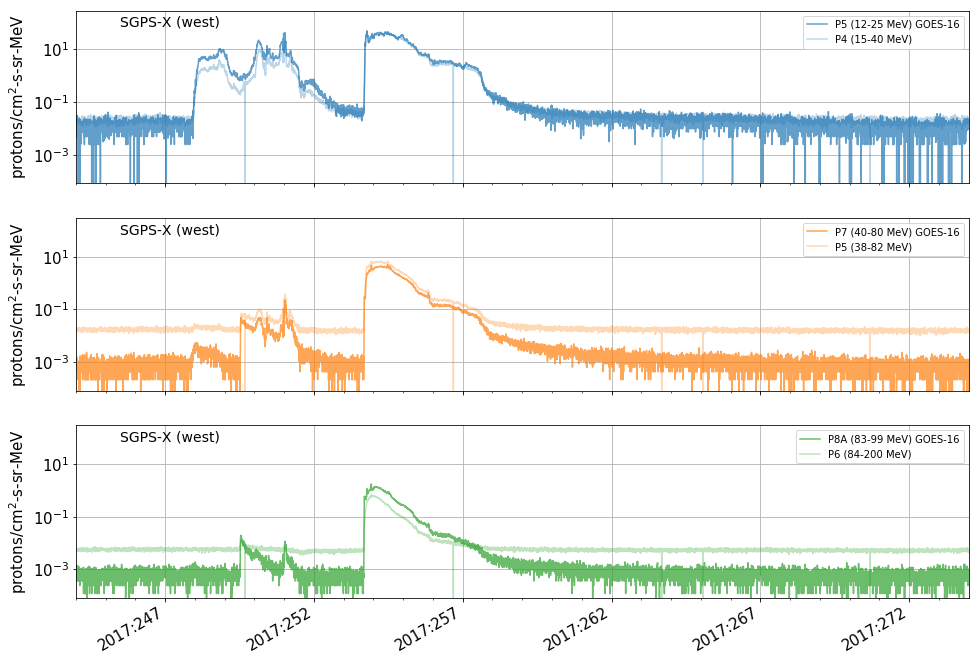

In [11]:
plt.figure(figsize=[16, 12])
plt.subplot(3, 1, 1)
plot_compare_flare_profiles(k, 4, 5, 0)
plt.subplot(3, 1, 2)
plot_compare_flare_profiles(k, 5, 7, 1)
plt.subplot(3, 1, 3)
plot_compare_flare_profiles(k, 6, 8, 2)

__Figure:__ A comparison of the 2017 strong flare observed with an old generation GOES satellite (Replan Central archive) and a new generation GOES-16 satellite (NOAA website). The "pale" colors represent the three channels on GOES-13/14/15 that were used to compute the HRC shield proxy. The darker colors represent the three GOES-16 channels proposed to replace the old channels. It can be noticed that the background level differs significantly between the old and new GOES instruments (up to > an order of magnitude), and the difference is not constant between the channels. However, near the peak of the flare, the fluxes of the two instruments are comparable (top/middle pannels) or different by significantly less than an order of magnitude (bottom pannel).

Confirming that GOES-16 levels in those three channels before and after the flare are in agreement with the levels observed in Jan 2021:

In [12]:
# Factor of 1000 to convert the units from ``per keV`` to ``per MeV``
chan = 5 # GOES-16
print(chan_label_g16[5],
      np.mean(ProtonFluxes[:,k,5][:100]) * 1000,  # before the 2017 flare
      np.mean(ProtonFluxes[:,k,5][-100:]) * 1000, # after the 2017 flare 
      np.mean(goes_arc['p5'][arc2021_flt]))       # 2021

P5 (12-25 MeV) 0.0129387444758 0.0121132970889 0.0119217830027


In [13]:
chan = 7 # GOES-16
print(chan_label_g16[chan],
      np.mean(ProtonFluxes[:,k,chan][:100]) * 1000,
      np.mean(ProtonFluxes[:,k,chan][-100:]) * 1000,
      np.mean(goes_arc['p7'][arc2021_flt]))

P7 (40-80 MeV) 0.000790953492924 0.000711228665295 0.00178993899039


In [14]:
chan = 8 # GOES-16
print(chan_label_g16[chan],
      np.mean(ProtonFluxes[:,k,chan][:100]) * 1000,
      np.mean(ProtonFluxes[:,k,chan][-100:]) * 1000,
      np.mean(goes_arc['p8a'][arc2021_flt]))

P8A (83-99 MeV) 0.000662636352899 0.000611664290773 0.000813574699107


# HRC shield proxy

In [15]:
# HRC proxy, use old coefficients on new GOES-16 channels
proton_fluxes = [ProtonFluxes[:, :, 5],  # P5
                 ProtonFluxes[:, :, 7],  # P7
                 ProtonFluxes[:, :, 8]]  # P8A
proton_fluxes = np.array(proton_fluxes) * 1000  # convert proton fluxes to ``per MeV``
HRCProxy_2017 = calc_HRCProxy(proton_fluxes)

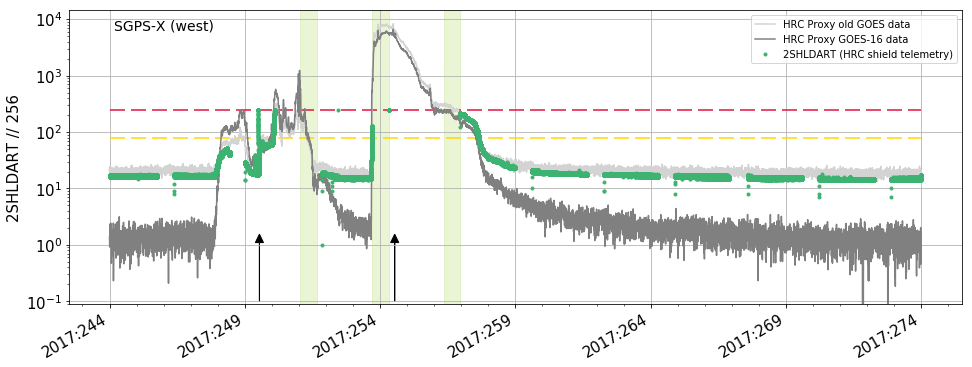

In [16]:
hrcproxy_correction = 0
plt.figure(figsize=[16, 6])
plot_compare_old_new_proxy(k, arc2017_flt, HRCProxy_2017, hrcproxy_correction,
                           shld2017, shld2017_flt)

ax = plt.gca()

rad_zones = [{'start': '2017:251:01:10:10.909', 'stop': '2017:251:16:09:45.863'},
             {'start': '2017:253:16:41:10.694', 'stop': '2017:254:07:41:09.649'},
             {'start': '2017:256:08:56:29.503', 'stop': '2017:256:22:46:03.503'}]
    
for rad_zone in rad_zones:
    x1 = DateTime(rad_zone['start']).plotdate
    x2 = DateTime(rad_zone['stop']).plotdate
    ax.axvspan(x1, x2, alpha=0.2, color='yellowgreen')

rad_shutdown_times = DateTime([621089952.184, 621521958.184]).plotdate
for tt in rad_shutdown_times:
    plt.arrow(tt, 0.1, 0, 1, head_width=0.3, color='k')

__Figure:__ The HRC shield proxies computed with old (light gray) and new (dark gray) GOES data, using the __old coefficients__, are compared with the Chandra's HRC shield rate telemetry. The yellow dashed line marks MTA's yellow alert limit. The red dashed line marks 250 counts/sample at which RADMON will trigger SCS 107 (SI safing action). The arrows mark two instances of radiation shutdown. Shaded areas mark radiation zones.

### Questions
* Can we correct for the lower background level of the GOES-16 instrument?
* Is it important to correct for the lower background level given that the new proxy appears to work relatively well when the proton flux is high?

In [17]:
# Figure out HRC proxy correction at the low proton flux epoch (Jan 2021)
proton_fluxes = [goes_arc['p5'][arc2021_flt],
                 goes_arc['p7'][arc2021_flt],
                 goes_arc['p8a'][arc2021_flt]]
HRCProxy_2021 = calc_HRCProxy(proton_fluxes)

In [18]:
# Guess
hrcproxy_correction = 16

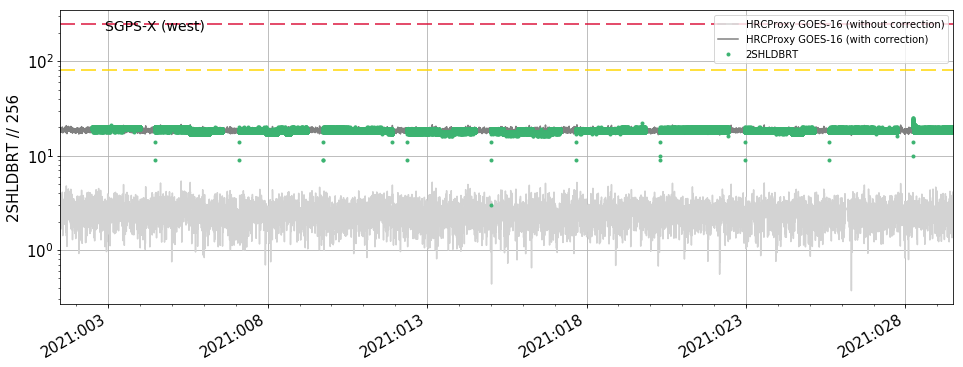

In [19]:
plt.figure(figsize=[16, 6])
plot_cxctime(goes_arc['secs'][arc2021_flt], HRCProxy_2021,
             color='lightgray', label="HRCProxy GOES-16 (without correction)")

plot_cxctime(goes_arc['secs'][arc2021_flt], HRCProxy_2021 + hrcproxy_correction,
             color='gray', label="HRCProxy GOES-16 (with correction)")

plot_cxctime(shld2021.times[shld2021_flt], shld2021.vals[shld2021_flt],
         color='mediumseagreen', marker='.', ls='None', label="2SHLDBRT")

x1 = DateTime('2021:001').plotdate
x2 = DateTime('2021:029').plotdate
plt.hlines([250], x1, x2, color='crimson', linestyle=(0, (10, 4)))
plt.hlines([80], x1, x2, color='gold', linestyle=(0, (10, 4)))
ax = plt.gca()
plot_format(ax, k)
plt.xlim([x1, x2])
plt.ylabel('2SHLDBRT // 256');

__Figure:__ Utilizing the Jan 2021 telemetry and GOES-16 data, it would appear that an additive term, ``hrcproxy_correction = 16``, is sufficient to correct for the lower background level in the GOES-16 instrument.

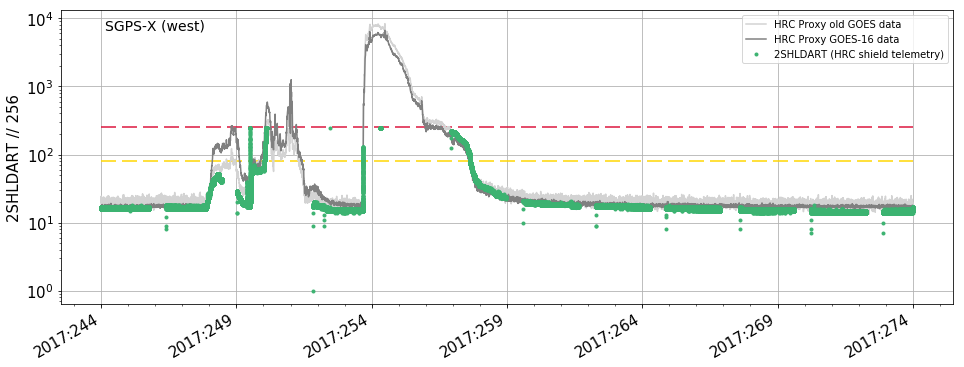

In [20]:
hrcproxy_correction = 16

plt.figure(figsize=[16, 6])
plot_compare_old_new_proxy(k, arc2017_flt,
                           HRCProxy_2017, hrcproxy_correction,
                           shld2017, shld2017_flt)

__Figure:__ HRC proxy with the additive term, ``hrcproxy_correction = 16``, for the 2017 flare data.

In [21]:
# HRC proxy at the time of the C/M Dec 2020 class flare
# using old coefficients on new G16 channels
proton_fluxes = [goes_arc['p5'][arc2020_flt],
                 goes_arc['p7'][arc2020_flt],
                 goes_arc['p8a'][arc2020_flt]]
HRCProxy_Cflare = calc_HRCProxy(proton_fluxes)

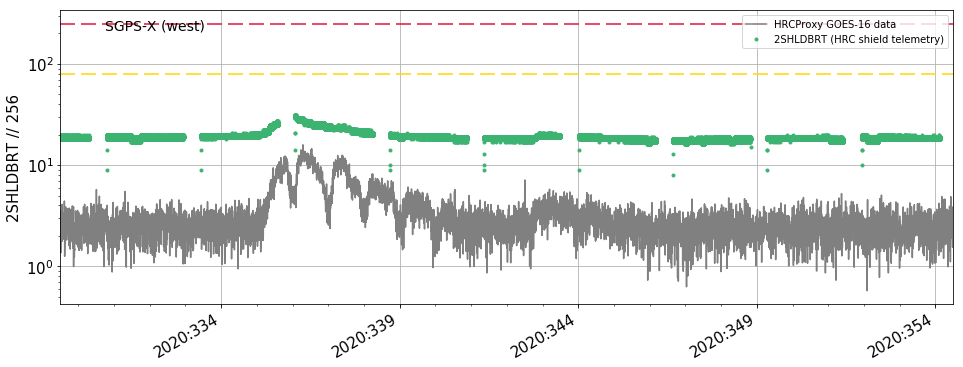

In [22]:
hrcproxy_correction = 0

plt.figure(figsize=[16, 6])
plot_telemetry_proxy_model(arc2020_flt, HRCProxy_Cflare, hrcproxy_correction,
                           shld2020, shld2020_flt)

__Figure:__ HRC proxy without the additive term for the 2020 C/M-class flare data.

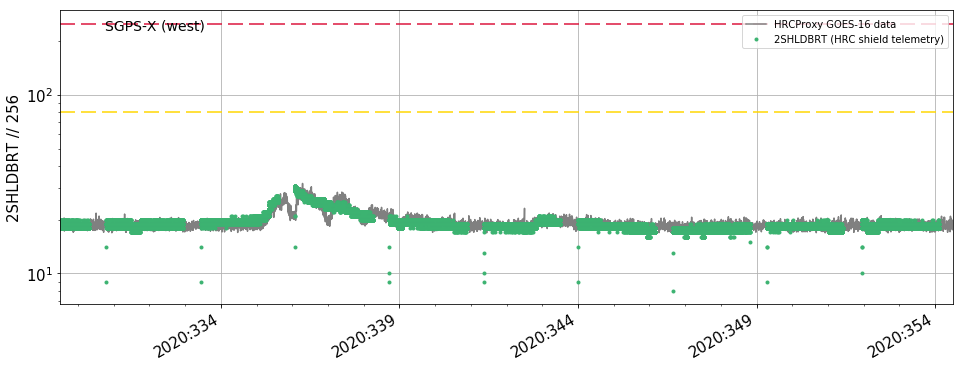

In [23]:
hrcproxy_correction = 16

plt.figure(figsize=[16, 6])
plot_telemetry_proxy_model(arc2020_flt, HRCProxy_Cflare, hrcproxy_correction,
                           shld2020, shld2020_flt)

__Figure:__ HRC proxy with the additive term correcting for the difference in background level between the old and new GOES for the 2020 C/M-class flare data.